In [1]:
%pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Note: you may need to restart the kernel to use updated packages.
Skipping, found downloaded files in "./rice-type-classification" (use force=True to force download)


In [2]:
import torch

# 1. 检查版本
print(f"PyTorch版本: {torch.__version__}")  # 应显示你安装的torch版本

# 2. 检查CUDA支持（GPU用户）
print(f"CUDA可用: {torch.cuda.is_available()}")  # 应为True
print(f"CUDA版本: {torch.version.cuda}")  # 应匹配安装的CUDA
print(f"显卡型号: {torch.cuda.get_device_name(0)}")  # 显示NVIDIA显卡名

PyTorch版本: 2.6.0+cu126
CUDA可用: True
CUDA版本: 12.6
显卡型号: NVIDIA GeForce RTX 4060 Laptop GPU


In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from rich.progress import track
from tqdm import tqdm
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
data_df = pd.read_csv("rice-type-classification/riceClassification.csv")
data_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [5]:
print(data_df.shape)
data_df.dropna(inplace= True)
data_df.drop(['id'], axis=1, inplace=True)
print(data_df.shape)
data_df.head()

(18185, 12)
(18185, 11)


,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [6]:
print(data_df['Class'].unique())
print(data_df['Class'].value_counts())

[1 0]
Class
1    9985
0    8200
Name: count, dtype: int64


In [7]:
original_df = data_df.copy()
for column in data_df.columns:
    data_df[column] = data_df[column] / data_df[column].abs().max()

data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [8]:
X = np.array(data_df.iloc[:, :-1])
Y = np.array(data_df.iloc[:, -1])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(12729, 10)
(2728, 10)
(2728, 10)


In [10]:
class dataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype = torch.float32).to(device)
        self.Y = torch.tensor(Y, dtype = torch.float32).to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [11]:
training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)

In [12]:
train_dataloader = DataLoader(training_data, batch_size=8, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=8, shuffle=True)
testing_dataloader = DataLoader(testing_data, batch_size=8, shuffle=True)

In [13]:
HIDDEN_NEURONS = 10
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)
        self.linear = nn.Linear(HIDDEN_NEURONS, 1)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        x = self.input_layer(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

model = Model().to(device)

In [14]:
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [15]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=1e-3)

In [18]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

# pbar = tqdm(range(epochs), desc='Training', unit='epoch', leave=True)

epochs = 10
for epoch in track(range(epochs), style="yellow"):
    total_loss_train = 0
    total_acc_train = 0
    total_loss_validation = 0
    total_acc_validation = 0

    for data in train_dataloader:
        inputs, labels = data
        
        prediction = model(inputs).squeeze(1)

        batch_loss = criterion(prediction, labels)

        total_loss_train += batch_loss.item() * inputs.shape[0]

        acc = ((prediction).round() == labels).sum().item()

        total_acc_train += acc

        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    with torch.no_grad():
        for data in validation_dataloader:
            inputs, labels = data

            prediction = model(inputs).squeeze(1)
            batch_loss = criterion(prediction, labels)

            total_loss_validation += batch_loss.item()  * inputs.shape[0]
            acc = ((prediction).round() == labels).sum().item()

            total_acc_validation += acc

    total_loss_train_plot.append(round(total_loss_train / training_data.__len__(), 4))
    total_acc_train_plot.append(round(total_acc_train / training_data.__len__() * 100, 4))
    total_loss_validation_plot.append(round(total_loss_validation / validation_data.__len__(), 4))
    total_acc_validation_plot.append(round(total_acc_validation / validation_data.__len__() * 100, 4))

    # # 更新tqdm描述（关键修改点）
    # pbar.set_description(
    #     f'❇️  Train: Loss {round(total_loss_train / training_data.__len__(), 4)} ● Acc {round(total_acc_train / training_data.__len__() * 100, 4)}%'
    #     f'🔍  Val:   Loss {round(total_loss_validation / validation_data.__len__() * 100, 4)} ● Acc {round(total_acc_validation / validation_data.__len__() * 100, 4)}%',
    #     refresh=True
    # )


    # print(f'''
    # Epoch no. {epoch+1} 
    # Train Loss: {round(total_loss_train / training_data.__len__(), 4)} 
    # Train Accuracy {round(total_acc_train / training_data.__len__() * 100, 4)}
    # Validation Loss: {round(total_loss_validation / validation_data.__len__() * 100, 4)}
    # Validation Accuracy: {round(total_acc_validation / validation_data.__len__() * 100, 4)}
    #             ''')
    # print("="*35)

Output()

In [35]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

pbar = tqdm(range(epochs), desc='Training', unit='epoch', leave=True)

epochs = 10
for epoch in pbar:
    total_loss_train = 0
    total_acc_train = 0
    total_loss_validation = 0
    total_acc_validation = 0

    for data in train_dataloader:
        inputs, labels = data
        
        prediction = model(inputs).squeeze(1)

        batch_loss = criterion(prediction, labels)

        total_loss_train += batch_loss.item() * inputs.shape[0]

        acc = ((prediction).round() == labels).sum().item()

        total_acc_train += acc

        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    with torch.no_grad():
        for data in validation_dataloader:
            inputs, labels = data

            prediction = model(inputs).squeeze(1)
            batch_loss = criterion(prediction, labels)

            total_loss_validation += batch_loss.item()  * inputs.shape[0]
            acc = ((prediction).round() == labels).sum().item()

            total_acc_validation += acc

    total_loss_train_plot.append(round(total_loss_train / training_data.__len__(), 4))
    total_acc_train_plot.append(round(total_acc_train / training_data.__len__() * 100, 4))
    total_loss_validation_plot.append(round(total_loss_validation / validation_data.__len__(), 4))
    total_acc_validation_plot.append(round(total_acc_validation / validation_data.__len__() * 100, 4))

    # 更新tqdm描述（关键修改点）
    pbar.set_description(
        f'❇️  Train: Loss {round(total_loss_train / training_data.__len__(), 4)} ● Acc {round(total_acc_train / training_data.__len__() * 100, 4)}%'
        f'🔍  Val:   Loss {round(total_loss_validation / validation_data.__len__() * 100, 4)} ● Acc {round(total_acc_validation / validation_data.__len__() * 100, 4)}%',
        refresh=True
    )


    # print(f'''
    # Epoch no. {epoch+1} 
    # Train Loss: {round(total_loss_train / training_data.__len__(), 4)} 
    # Train Accuracy {round(total_acc_train / training_data.__len__() * 100, 4)}
    # Validation Loss: {round(total_loss_validation / validation_data.__len__() * 100, 4)}
    # Validation Accuracy: {round(total_acc_validation / validation_data.__len__() * 100, 4)}
    #             ''')
    # print("="*35)

❇️  Train: Loss 0.0412 ● Acc 98.5938%🔍  Val:   Loss 3.5118 ● Acc 98.9003%: 100%|██████████| 10/10 [00:22<00:00,  2.29s/epoch]


In [ ]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for data in testing_dataloader:
        inputs, labels = data

        prediction = model(inputs).squeeze(1)

        batch_loss_test = criterion(prediction, labels).item()
        total_loss_test += batch_loss_test

        acc_test = ((prediction).round() == labels).sum().item()
        total_acc_test += acc_test

print(f"Accuracy {round(total_acc_test / testing_data.__len__() * 100, 4)}")

Accuracy 98.3504


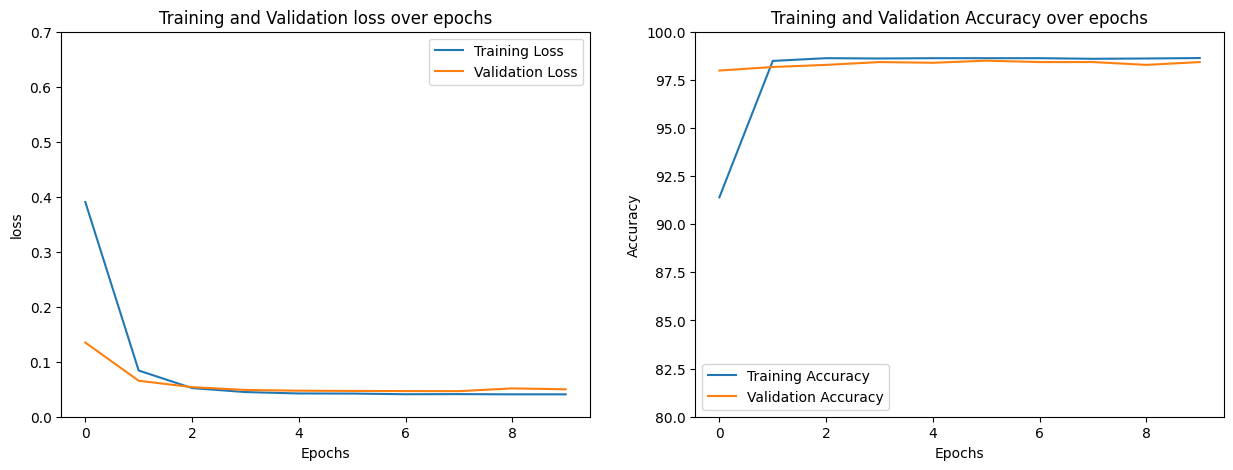

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

axs[0].plot(total_loss_train_plot, label = 'Training Loss')
axs[0].plot(total_loss_validation_plot, label = 'Validation Loss')
axs[0].set_title("Training and Validation loss over epochs")
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('loss')
axs[0].set_ylim([0, 0.7])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = 'Training Accuracy')
axs[1].plot(total_acc_validation_plot, label = 'Validation Accuracy')
axs[1].set_title("Training and Validation Accuracy over epochs")
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([80, 100])
axs[1].legend()

plt.show()

In [ ]:
# area = float(input("Area: "))/original_df['Area'].abs().max()
# MajorAxisLength = float(input("Major Axis Length: "))/original_df['MajorAxisLength'].abs().max()
# MinorAxisLength = float(input("Minor Axis Length: "))/original_df['MinorAxisLength'].abs().max()
# Eccentricity = float(input("Eccentricity: "))/original_df['Eccentricity'].abs().max()
# ConvexArea = float(input("Convex Area: "))/original_df['ConvexArea'].abs().max()
# EquivDiameter = float(input("EquivDiameter: "))/original_df['EquivDiameter'].abs().max()
# Extent = float(input("Extent: "))/original_df['Extent'].abs().max()
# Perimeter = float(input("Perimeter: "))/original_df['Perimeter'].abs().max()
# Roundness = float(input("Roundness: "))/original_df['Roundness'].abs().max()
# AspectRation = float(input("AspectRation: "))/original_df['AspectRation'].abs().max()

# my_inputs = [area, MajorAxisLength, MinorAxisLength, Eccentricity, ConvexArea, EquivDiameter, Extent, Perimeter, Roundness, AspectRation]

# print("="*20)
# model_inputs = torch.Tensor(my_inputs).to(device)
# prediction = (model(model_inputs))
# print(prediction)
# print("Class is: ", round(prediction.item()))